In [6]:
from rdkit import Chem
import pandas as pd

In [9]:
df1 = pd.read_csv("2c8_train_data.csv")

In [10]:
df2 = pd.read_csv("2c8_test_data.csv")

In [11]:
df3 = pd.read_csv("2c8_valid_data.csv")

In [16]:
def out_sdf(lig_list, filename):
    writer = Chem.SDWriter(filename)
    for i in lig_list:
        writer.write(i)
    writer.close()
    return

In [22]:
cpd_list = []
for idx, row in df3.iterrows():
    if idx % 5000 == 0:
        print(idx, 'have been processed')
    try:
        smi = row['SMILES']
        mol = Chem.MolFromSmiles(smi)
        for prop in df.columns:
            prop_value = str(row[prop])
            mol.SetProp(prop, prop_value)
    except Exception as e:
        print(idx, e)
    cpd_list.append(mol)
len(cpd_list)

0 have been processed


86

In [23]:
out_sdf(cpd_list, '2c8_valid_data.sdf')

In [24]:
from rdkit.Chem import AllChem, DataStructs
import numpy as np
from sklearn.model_selection import train_test_split

In [25]:
fname1 = '2c8_train_data.sdf'
fname2 = '2c8_test_data.sdf'
fname3 = '2c8_valid_data.sdf'

In [36]:
x_valid_mol = []
y_valid = []
for mol in Chem.SDMolSupplier(fname3):
    x_valid_mol.append(mol)
    y_valid.append(mol.GetIntProp('CLASS'))

In [31]:
len(x_train_mol)

340

In [33]:
len(x_test_mol)

107

In [38]:
len(x_valid_mol)

86

In [39]:
from joblib import dump, load

In [42]:
x_train = load('x_train_ecfp4.pkl')
x_test = load('x_test_ecfp4.pkl')
x_valid = load('x_valid_ecfp4.pkl')

In [48]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [49]:
seed = 42

In [50]:
cv = StratifiedKFold(n_splits=10, random_state=seed)

D:\Anaconda3\envs\deepchem\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [1077]:
from sklearn.preprocessing import StandardScaler

In [58]:
scale = StandardScaler().fit(x_train)
x_train_scaled = scale.transform(x_train)
x_test_scaled = scale.transform(x_test)
x_valid_scaled = scale.transform(x_valid)

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [935]:
param_grid = {}
# 'max_depth': np.arange(10, 100, 10)
# 'n_estimators': np.arange(100, 1000, 50)
# 'max_features': np.arange(100, 250, 1)

In [931]:
rf = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=seed, n_estimators=200, max_features=3), param_grid=param_grid, cv=cv, n_jobs=-1, verbose=1)

In [932]:
rf.fit(x_train_scaled, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=3,
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=200, n_jobs=None,
                                         

In [933]:
rf.best_params_

{'min_samples_split': 20}

In [934]:
rf.best_score_

0.7970588235294117

In [1112]:
rf_2c8 = RandomForestClassifier(class_weight='balanced', random_state=seed, n_estimators=200, max_features=3)

In [1110]:
rf_2c8.fit(x_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [583]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import matthews_corrcoef, accuracy_score, roc_auc_score, make_scorer, recall_score

In [207]:
matthews = make_scorer(matthews_corrcoef)

In [208]:
specificity = make_scorer(recall_score, pos_label=0)

In [1082]:
score1 = cross_val_score(rf_2c8, x_train_scaled, y_train, cv=cv, scoring='accuracy')

In [1083]:
score1.mean()

0.8264705882352941

In [1084]:
score2 = cross_val_score(rf_2c8, x_train_scaled, y_train, cv=cv, scoring='roc_auc')

In [1085]:
score2.mean()

0.8869736842105264

In [1086]:
score3 = cross_val_score(rf_2c8, x_train_scaled, y_train, cv=cv, scoring=matthews)

In [1087]:
score3.mean()

0.6434649032228571

In [1088]:
score4 = cross_val_score(rf_2c8, x_train_scaled, y_train, cv=cv, scoring='recall')

In [1070]:
score4.mean()

0.9094736842105263

In [1089]:
score5 = cross_val_score(rf_2c8, x_train_scaled, y_train, cv=cv, scoring=specificity)

In [1090]:
score5.mean()

0.7595238095238095

In [1091]:
y_pred = rf_2c8.predict(x_test_scaled)

In [1092]:
y_pred

array([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1])

In [1093]:
accuracy_score(y_test, y_pred)

0.8037383177570093

In [1094]:
roc_auc_score(y_test, rf_2c8.predict_proba(x_test_scaled)[:,1])  # rf_2c8.predict_proba(x_test_scaled)[:,1] 预测为 “1” 的概率，[:,1]取二维数组的第二维

0.8473762010347375

In [1044]:
matthews_corrcoef(y_test, y_pred)

0.5800270450133965

In [1045]:
recall_score(y_test, y_pred) # sensitivity

0.8636363636363636

In [1046]:
recall_score(y_test, y_pred, pos_label=0) # specificity

0.7073170731707317

In [1008]:
import matplotlib.pyplot as plt

0.8264705882352941 2


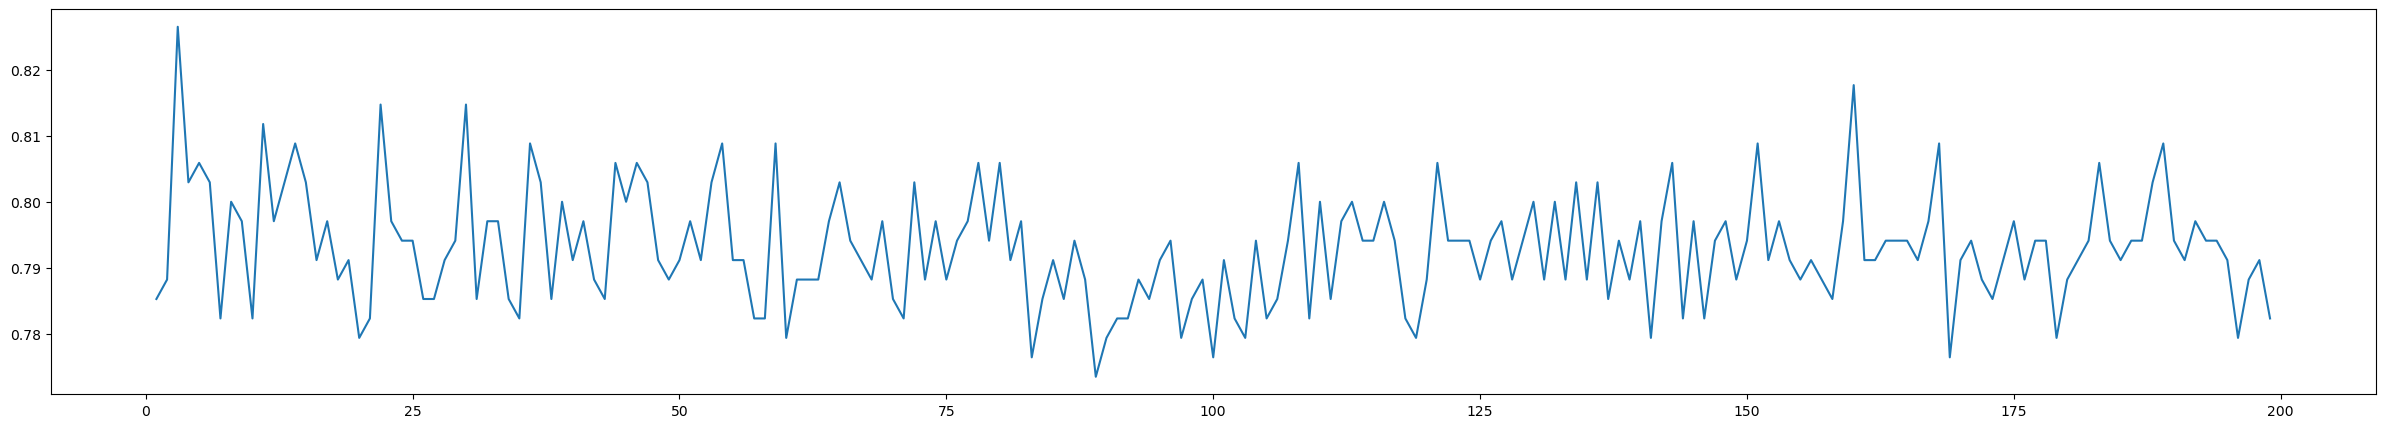

In [883]:
scorel = []
for i in range(1,200,1):
    rf_2c8 = RandomForestClassifier(class_weight='balanced', random_state=seed, n_estimators=200, max_features=i)
    score = cross_val_score(rf_2c8, x_train_scaled, y_train, cv=cv, scoring='accuracy').mean()
    scorel.append(score)
print(max(scorel),(scorel.index(max(scorel))))
plt.figure(figsize=[30,5])
plt.plot(range(1,200,1), scorel)
plt.show()

0.8037383177570093 2


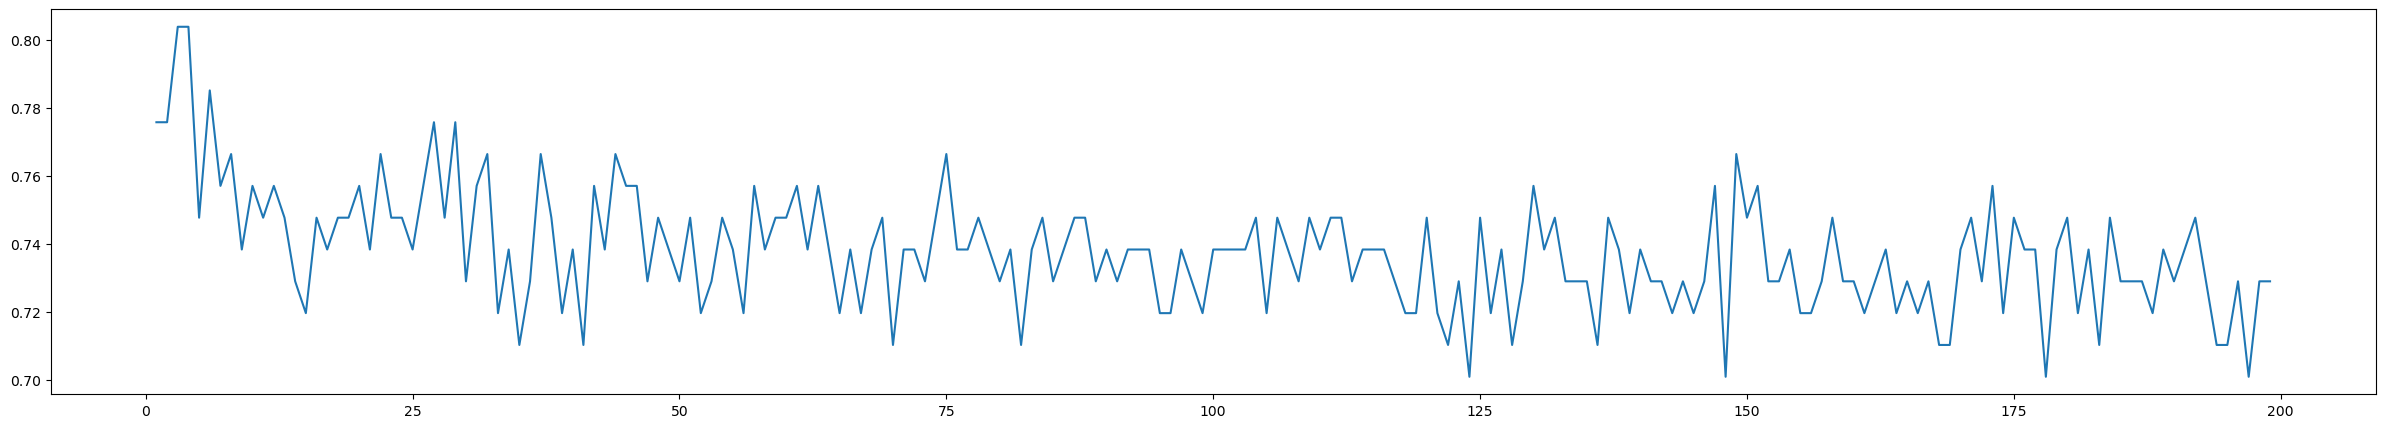

In [884]:
scores = []
for i in range(1, 200, 1):
    rf_2c8 = RandomForestClassifier(class_weight='balanced', random_state=seed, n_estimators=200, max_features=i)
    rf_2c8.fit(x_train_scaled, y_train)
    y_pred = rf_2c8.predict(x_test_scaled)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)
print(max(scores),(scores.index(max(scores))))
plt.figure(figsize=[30,5])
plt.plot(range(1, 200, 1), scores)
plt.show()

In [955]:
y_pred_valid = rf_2c8.predict(x_valid_scaled)

In [956]:
y_pred_valid

array([0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0])

In [957]:
accuracy_score(y_valid, y_pred_valid)

0.813953488372093

In [958]:
roc_auc_score(y_valid, rf_2c8.predict_proba(x_valid_scaled)[:,1])

0.9124386252045826

In [959]:
matthews_corrcoef(y_valid, y_pred_valid)

0.6246590289143481

In [960]:
recall_score(y_valid, y_pred_valid)

0.8297872340425532

In [961]:
recall_score(y_valid, y_pred_valid, pos_label=0)

0.7948717948717948

In [962]:
dump(rf_2c8, '2c8_ecfp4_rf.pkl', compress=3)

['2c8_ecfp4_rf.pkl']